Read necessary libraries 

In [1]:
from matplotlib import pyplot as plt, rcParams, animation
import scipy, seaborn as sns, matplotlib
from scipy.cluster import hierarchy as hc
matplotlib.rc('animation', html='html5')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=5, linewidth=110, suppress=True)
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import ben

In [2]:
path = 'data/thesis/'

### I. Data

1. 12 industry ETFs, each industry ETF is a column in a dataframe called "ind", these ETFs are designed by BlackRock
2. 07 factor ETFs representing factor investing, each strategy is a column in a dataframe called "factor", these ETFs are designed by BlackRock
3. S&P500 as market index and risk free rate (T-Bill one-month return) as rf

In [3]:
ind = ben.get_df('sector_return.xlsx', path); ind.head(2)

,IDU,IYC,IYF,IYG,IYH,IYJ,IYK,IYM,IYR,IYT,IYW,IYZ
Date,,,,,,,,,,,,
2013-08,-0.053026,-0.037844,-0.049613,-0.051423,-0.035187,-0.022068,-0.033417,-0.001690,-0.065325,-0.032828,-0.006214,-0.040458
2013-09,0.005246,0.054969,0.028347,0.024893,0.028868,0.052925,0.021505,0.043441,0.024904,0.053466,0.026443,0.029104


In [4]:
ind.shape

(89, 12)

In [5]:
factor = ben.get_df('factor_return.xlsx', path); factor.head(2)

,EEMV,EFAV,MTUM,QUAL,SIZE,USMV,VLUE
Date,,,,,,,
2013-08,-0.040745,-0.017007,-0.035704,-0.020750,-0.033024,-0.032573,-0.031201
2013-09,0.065892,0.054481,0.030237,0.038127,0.031530,0.025530,0.028047


In [6]:
factor.shape

(89, 7)

In [7]:
market_rf = ben.get_df_excel('sp500.xlsx', path); market_rf.head(2)

,Risk free,Market return
Date,,
2013-08,0.000009,-0.031298
2013-09,0.000008,0.029749


In [8]:
market_rf.shape

(89, 2)

In [9]:
mar_ret = market_rf['Market return'].mean()
mar_vol = market_rf['Market return'].std()
market = (mar_ret, mar_vol)
market

(0.009845607748314607, 0.04023132413238701)

In [10]:
rf = market_rf['Risk free'].mean()
rf

0.0005907303370786517

### II. Descriptive statistics

In [59]:
l = ["Sharpe ratio", "Skewness", "Kurtosis", "VaR", "annu. return", "annu. vol"]
func_name = [ben.sharpe_ratio, ben.get_skewness, ben.get_kurtosis, ben.var_historic, 
             ben.annualize_ret, ben.annualize_vol]

In [60]:
def get_descriptive (df, l, func_name):
    des = df.describe()
    for i in range(0, len(l)):
        row_name = l[i]
        func = func_name[i]
        if row_name == "Sharpe ratio":
            row_val = func(df, rf).values
        else:
            row_val = func(df).values
        des.loc[-1] = row_val
        des.rename(index={-1: row_name}, inplace=True)
    return des

In [61]:
ind_des = get_descriptive(ind, l, func_name)
ind_des

,IDU,IYC,IYF,IYG,IYH,IYJ,IYK,IYM,IYR,IYT,IYW,IYZ
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,0.000242,0.003190,0.001772,0.009381,0.010140,0.004413,0.008173,0.006772,0.003837,0.008810,0.009179,0.001801
std,0.066115,0.092505,0.069744,0.058649,0.040766,0.072140,0.041077,0.055106,0.044371,0.054617,0.094143,0.043159
min,-0.500868,-0.742240,-0.475615,-0.224605,-0.099103,-0.489512,-0.123958,-0.164818,-0.204005,-0.180762,-0.738336,-0.112183
25%,-0.019774,-0.012720,-0.021237,-0.020734,-0.009760,-0.020049,-0.015303,-0.022288,-0.016697,-0.011662,-0.017074,-0.025273
50%,0.012605,0.010803,0.017944,0.021254,0.010405,0.009759,0.006491,0.007687,0.005065,0.011699,0.021401,0.000310
75%,0.032318,0.034728,0.033936,0.038968,0.037505,0.035959,0.027978,0.035130,0.029183,0.041493,0.047152,0.027958
max,0.084260,0.155848,0.146394,0.177839,0.129286,0.156714,0.127564,0.171214,0.114758,0.118417,0.146240,0.119835
Sharpe ratio,-0.141431,-0.177426,-0.066634,0.467423,0.829107,0.051604,0.640175,0.337966,0.220628,0.478591,0.038311,0.067455
Skewness,-5.012742,-5.924199,-3.884567,-0.655885,-0.263935,-3.725537,-0.090281,-0.009428,-0.984885,-0.759845,-5.661164,0.237314


In [75]:
ind_des.to_excel(f'{path}industry_descriptive.xlsx') # export to excel

In [97]:
ind_des.to_latex(f'{path}ind_des.tex')

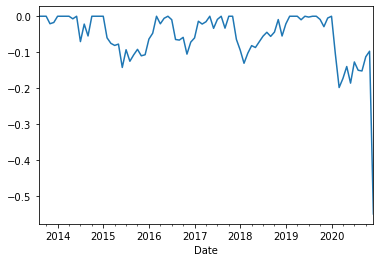

In [58]:
ben.drawdown(ind.IDU)['Drawdown'].plot()

In [62]:
factor_des = get_descriptive(factor, l, func_name)
factor_des

,EEMV,EFAV,MTUM,QUAL,SIZE,USMV,VLUE
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,0.003573,0.005456,0.014154,0.011736,0.010718,0.010156,0.008362
std,0.038336,0.029994,0.040643,0.039724,0.043765,0.032169,0.047238
min,-0.120690,-0.098373,-0.115587,-0.114189,-0.182781,-0.113379,-0.183625
25%,-0.020833,-0.009781,-0.009944,-0.007563,-0.006475,-0.004941,-0.011091
50%,0.008851,0.008436,0.017960,0.010710,0.013109,0.012605,0.012419
75%,0.029075,0.024261,0.037432,0.036972,0.034141,0.030596,0.034136
max,0.092282,0.087952,0.117017,0.122779,0.143132,0.093686,0.164269
Sharpe ratio,0.256091,0.588553,1.219120,1.010397,0.810668,1.089034,0.548606
Skewness,-0.399998,-0.568746,-0.413289,-0.287832,-0.676955,-0.805963,-0.610647


In [64]:
market_des = get_descriptive(market_rf, l, func_name)
market_des

,Risk free,Market return
count,89.000000,89.000000
mean,0.000591,0.009846
std,0.000707,0.040231
min,-0.000037,-0.125119
25%,0.000020,-0.004189
50%,0.000171,0.015329
75%,0.001197,0.029749
max,0.002125,0.126844
Sharpe ratio,2.659089,0.813843
Skewness,0.836939,-0.381478


In [73]:
com = factor_des.merge(market_des, left_index=True, how='left', right_index=True)
com

,EEMV,EFAV,MTUM,QUAL,SIZE,USMV,VLUE,Risk free,Market return
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,0.003573,0.005456,0.014154,0.011736,0.010718,0.010156,0.008362,0.000591,0.009846
std,0.038336,0.029994,0.040643,0.039724,0.043765,0.032169,0.047238,0.000707,0.040231
min,-0.120690,-0.098373,-0.115587,-0.114189,-0.182781,-0.113379,-0.183625,-0.000037,-0.125119
25%,-0.020833,-0.009781,-0.009944,-0.007563,-0.006475,-0.004941,-0.011091,0.000020,-0.004189
50%,0.008851,0.008436,0.017960,0.010710,0.013109,0.012605,0.012419,0.000171,0.015329
75%,0.029075,0.024261,0.037432,0.036972,0.034141,0.030596,0.034136,0.001197,0.029749
max,0.092282,0.087952,0.117017,0.122779,0.143132,0.093686,0.164269,0.002125,0.126844
Sharpe ratio,0.256091,0.588553,1.219120,1.010397,0.810668,1.089034,0.548606,2.659089,0.813843
Skewness,-0.399998,-0.568746,-0.413289,-0.287832,-0.676955,-0.805963,-0.610647,0.836939,-0.381478


In [77]:
com.to_excel(f'{path}factor_and_sp500_descriptive.xlsx') # export to excel

In [108]:
# create correlation matrix
def corr_map (df, fig=(10, 8), tittle='Pearson Correlation Matrix'):
    mask = np.zeros_like(df[df.columns].corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=fig)
    plt.title(tittle,fontsize=23)
    sns.heatmap(df[df.columns].corr(),linewidths=0.25, vmax=1.0, square=True, cmap="BuGn",
                linecolor='w', annot=True, mask=mask, cbar_kws={"shrink": .75})
    plt.savefig(f'{path}{tittle}')
    return f.tight_layout()

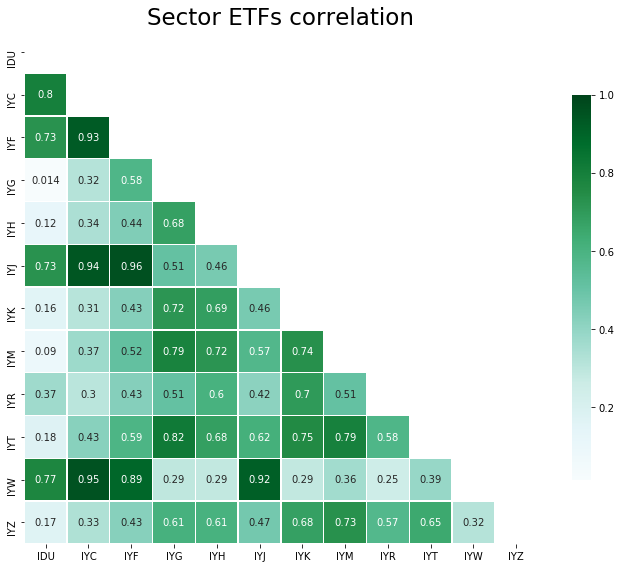

In [109]:
sec_corr = corr_map(ind, tittle="Sector ETFs correlation")
sec_corr

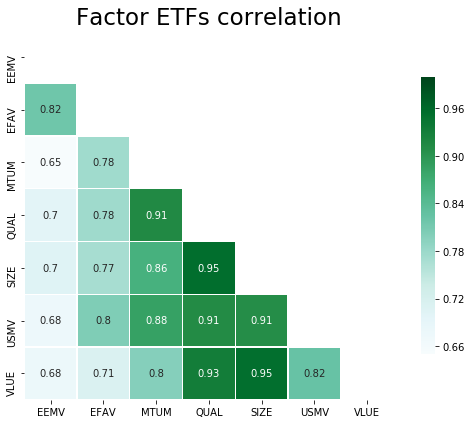

In [110]:
corr_map(factor, fig=(8,6), tittle="Factor ETFs correlation")